In [1]:
import os 
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import cv2
from sklearn.model_selection import train_test_split

In [2]:
DATASET_DIR = './Dataset/train/audio/'

In [3]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [4]:
# This block of code was insipired by the following link:
# https://github.com/OldBonhart/TensorFlow_Speech_Recognition_Challenge/blob/master/Train___EfficientNet.ipynb
labels = os.listdir(DATASET_DIR)
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR + label
    data_map[data_path] = label, os.listdir(data_path), ind
data_map.keys()
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR + label
    data_map[ind] = label, os.listdir(data_path), ind
    
df = pd.DataFrame(data_map.values(), 
                  columns=["label_name", "path", "label"])
df = df.set_index(['label_name', 'label'])
df.reset_index(inplace=True)
# background = df[df['label_name'] == '_background_noise_']
df = df[df['label_name'] != '_background_noise_']
rows = []
_ = df.apply(lambda row: [rows.append([row['label_name'], row['label'], nn]) 
                         for nn in row.path], axis=1)
df_new = pd.DataFrame(rows, columns=df.columns)
df_new.to_csv(r'speech_commands_dataset_all_labels.csv', index=True)
#print(df_new["label_name"].value_counts())
df_new

,label_name,label,path
0,right,0,988e2f9a_nohash_0.wav
1,right,0,1eddce1d_nohash_3.wav
2,right,0,93ec8b84_nohash_0.wav
3,right,0,6272b231_nohash_1.wav
4,right,0,439c84f4_nohash_1.wav
...,...,...,...
64716,four,30,93f30cc4_nohash_1.wav
64717,four,30,0c40e715_nohash_0.wav
64718,four,30,238c112c_nohash_0.wav
64719,four,30,173ae793_nohash_1.wav


In [5]:
train_df, val_df = train_test_split(df_new, stratify=df_new['label'], test_size=0.1)
train_df, test_df = train_test_split(train_df, stratify=train_df['label'], test_size=0.1)
print(train_df.shape, val_df.shape, test_df.shape)
print(train_df.dtypes)
print(train_df.head())

(52423, 3) (6473, 3) (5825, 3)
label_name    object
label          int64
path          object
dtype: object
      label_name  label                   path
56579         on     27  f5e44d34_nohash_0.wav
63422       four     30  0c2ca723_nohash_0.wav
46933      house     23  f5d09ebd_nohash_0.wav
56293         on     27  9886d8bf_nohash_4.wav
57224         on     27  62605293_nohash_1.wav


In [6]:
def data_generator(df, num_classes, batch_size):
    while True:
        batch_images = []
        batch_labels = []
        for _ in range(batch_size):
            idx = np.random.randint(len(df))  # Randomly select an index
            row = df.iloc[idx]
            signal_path = DATASET_DIR + row['label_name'] + '/' + row['path']
            samples, sample_rate = librosa.load(signal_path, mono=True, sr=None)
            freqs, times, spectrogram = log_specgram(samples, sample_rate)
            img = cv2.resize(spectrogram, (32, 32))
            # Normalization
            img = (img - np.mean(img)) / np.std(img)
            img = np.stack((img,) * 3, axis=-1).astype(np.float32)
            label = np.zeros(num_classes)
            label[row['label']] = 1  # Setting the corresponding class index to 1
            batch_images.append(img)
            batch_labels.append(label)
        yield np.array(batch_images), np.array(batch_labels)

In [7]:
input_shape = (32, 32, 3)
num_classes = len(labels)
epochs = 2
batch_size = 64

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Reshape
from keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Reshape((-1, 128)),
    LSTM(128),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/salveendutt/GithubRepos/Deep-Learning/.tfenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,831 (893.87 KB)

 Trainable params: 228,831 (893.87 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
def preprocess_data(row, num_classes):
    signal_path = DATASET_DIR + row['label_name'] + '/' + row['path']
    samples, sample_rate = librosa.load(signal_path, mono=True, sr=None)
    freqs, times, spectrogram = log_specgram(samples, sample_rate)
    img = cv2.resize(spectrogram, (32, 32))
    img = (img - np.mean(img)) / np.std(img)
    img = np.stack((img,) * 3, axis=-1).astype(np.float32)
    label = np.zeros(num_classes)
    label[row['label']] = 1
    return img, label

def create_dataset(df, num_classes, batch_size):
    def generator():
        for index, row in df.iterrows():
            img, label = preprocess_data(row, num_classes)
            yield img, label

    dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32), tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)))
    dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [10]:
train_dataset = create_dataset(train_df, num_classes, batch_size)
val_dataset = create_dataset(val_df, num_classes, batch_size)
test_dataset = create_dataset(test_df, num_classes, batch_size)
model.fit(train_dataset, epochs=epochs, batch_size=batch_size, validation_data=val_dataset)

Epoch 1/2


2024-05-04 12:10:18.043434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12595 of 52423
2024-05-04 12:10:38.041283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 41205 of 52423


     14/Unknown 40s 14ms/step - accuracy: 0.0363 - loss: 3.4284 

2024-05-04 12:10:46.783278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


    819/Unknown 51s 15ms/step - accuracy: 0.3753 - loss: 2.1378

2024-05-04 12:10:58.797077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Cellar/python@3.11/3.11.7_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


820/820 ━━━━━━━━━━━━━━━━━━━━ 57s 21ms/step - accuracy: 0.3758 - loss: 2.1361 - val_accuracy: 0.7660 - val_loss: 0.7753
Epoch 2/2


2024-05-04 12:11:04.169844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-04 12:11:14.183800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13752 of 52423
2024-05-04 12:11:34.183538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 40470 of 52423


 13/820 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7865 - loss: 0.7394

2024-05-04 12:11:42.200375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


817/820 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8005 - loss: 0.6720

2024-05-04 12:11:53.871563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


820/820 ━━━━━━━━━━━━━━━━━━━━ 54s 20ms/step - accuracy: 0.8006 - loss: 0.6718 - val_accuracy: 0.7993 - val_loss: 0.6393


2024-05-04 12:11:58.494264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

y_true = []
y_pred = []
test_generator = data_generator(test_df, num_classes, batch_size)

# Iterate over test data and collect true and predicted labels
for i in range(len(test_df) // batch_size):
    X_test_batch, y_test_batch = next(test_generator)
    y_true.extend(np.argmax(y_test_batch, axis=1))  # True classes
    y_pred.extend(np.argmax(model.predict(X_test_batch), axis=1))  # Predicted classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

Accuracy: 0.7991071428571429


([<matplotlib.axis.YTick at 0x3164b2390>,
 [Text(0, 0, 'right'),
  Text(0, 1, 'eight'),
  Text(0, 2, 'cat'),
  Text(0, 3, 'tree'),
  Text(0, 4, 'bed'),
  Text(0, 5, 'happy'),
  Text(0, 6, 'go'),
  Text(0, 7, 'dog'),
  Text(0, 8, 'no'),
  Text(0, 9, 'wow'),
  Text(0, 10, 'nine'),
  Text(0, 11, 'left'),
  Text(0, 12, 'stop'),
  Text(0, 13, 'three'),
  Text(0, 14, '_background_noise_'),
  Text(0, 15, 'sheila'),
  Text(0, 16, 'one'),
  Text(0, 17, 'bird'),
  Text(0, 18, 'zero'),
  Text(0, 19, 'seven'),
  Text(0, 20, 'up'),
  Text(0, 21, 'marvin'),
  Text(0, 22, 'two'),
  Text(0, 23, 'house'),
  Text(0, 24, 'down'),
  Text(0, 25, 'six'),
  Text(0, 26, 'yes'),
  Text(0, 27, 'on'),
  Text(0, 28, 'five'),
  Text(0, 29, 'off'),
  Text(0, 30, 'four')])

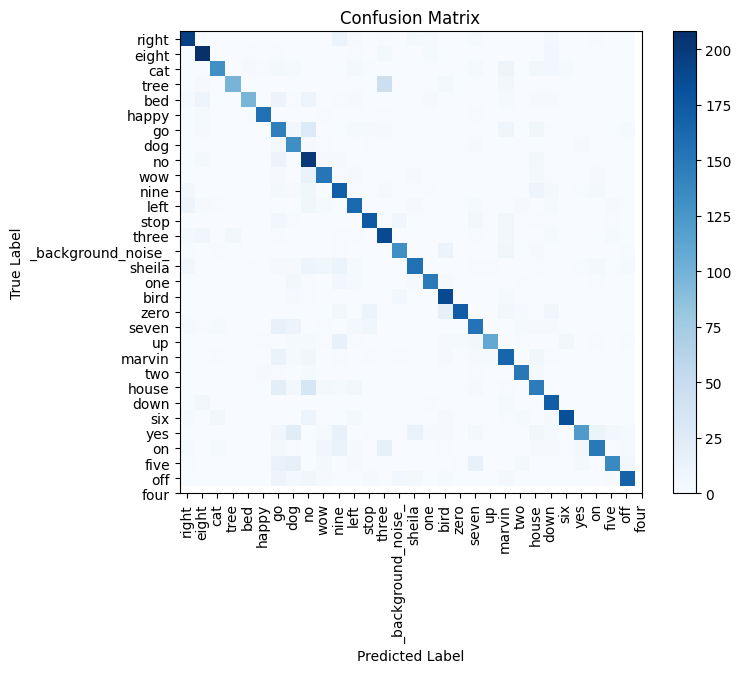

In [13]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Set tick labels
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(labels)), labels, rotation=0)